In [1]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
import numpy as np
from scipy.optimize import minimize
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式

from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

def plot_curve(ax2,x,y,color='black',title='', linestyle='-',xlim=[0,100],dx=20,
               ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', 
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1, 
               nonscatter=True, s0=10):
    if nonscatter:
        if color:
            ax2.plot(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, label=label)
        else:
            ax2.plot(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label)
    else:
        if color:
            ax2.scatter(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, 
                        label=label, s=s0)
        else:
            ax2.scatter(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label,
                        s=s0)
        
    ax2.set_xlabel(xlabel,font2)
    ax2.set_ylabel(ylabel,font2)
    
    # def format_funcx(value, tick_number, num_decimals=xnum_decimals):
    #     if num_decimals==0:
    #         return f'{value:.0f}'
    #     return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
    #     ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if xlim:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize=10,weight='bold')
       ax2.set_xlim(xlim)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=12,weight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')

h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
def exp_fitting(x,y, num=2):
    
    if num==2:
        # Calculate integrals
        iy1 = cumtrapz(y, x, initial=0)
        iy2 = cumtrapz(iy1, x, initial=0)


        # Get exponentials lambdas
        Y = np.column_stack((iy1, iy2,  x**2, x, np.ones_like(x)))
        A = pinv(Y) @ y
        
        if A[0]**2 + 4*A[1]<0 or A[0]>0 or A[1]>0:
            # 定义目标函数
            def objective(t):
                return np.linalg.norm(Y @ t - y)

            # 定义约束函数
            def constraint1(t):
                return t[0]**2 + 4*t[1]

            def constraint2(t):
                return  1e-6 - t[1] # 避免数值误差导致x[1]恰好等于0

            def constraint3(t):
                return 1e-6 - t[0]  # 避免数值误差导致x[0]恰好等于0


            # 初始猜测
            x0 = np.array([-1.2, -0.2, 0, 0, 0])

            # 定义约束
            cons = [{'type': 'ineq', 'fun': constraint1},
                    {'type': 'ineq', 'fun': constraint2},
                    {'type': 'ineq', 'fun': constraint3}]

            # 设置迭代次数
            options = {'maxiter': 10000}  # 将最大迭代次数设置为1000

            # 使用scipy.optimize.minimize求解问题
            solution = minimize(objective, x0, constraints=cons, options=options)
            A = solution.x


        lambdas = eig(np.array([[A[0], A[1]], [1, 0]]))[0]
        # print("Lambdas:", lambdas)

        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas[0] * x), np.exp(lambdas[1] * x)))
        P = pinv(X) @ y
        
    return lambdas, P

/home/wzl/anaconda/envs/neuron9/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO : Using neuron-nightly Package (Developer Version)
/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
cfiles =
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Im.mod" "/home/wzl/LFPy/project/conductance_measurement/real

--No graphics will be displayed.


# $L\{\Gamma\}(x_s,x_S,0)$ estimation

In [2]:
def est_input_resistantce(run_dt, passive=True, block='', name= '', setIh = False,  gIhbar_Ih = 0.):
   
    L5PC = h.L5PCtemplate(morphologyFilename)

    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
 
    if setIh:
        for sec in h.allsec():
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = gIhbar_Ih
        
    h.dt = run_dt
    h.tstop = 2000.
    h.v_init = -90.
    time = h.Vector().record(h._ref_t)
    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    

    # Initialize voltage clamp
    iclamp = h.IClamp(L5PC.soma[0](0.5))
    iclamp.delay = 800.
    iclamp.dur = 1000.
    iclamp.amp = 0.
    
    i_clamp = h.Vector().record(iclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()
        
        
    # Main simulation loop
    def main():
    
        i_amp = np.arange(1,20)*0.0005
        V_peak = np.zeros(len(i_amp))
        iclamp.amp = 0.
        go()
        recv0 = np.array(recv.to_python())
        V_rest = recv0[-1]
        print(V_rest)
        
        for i in range(len(i_amp)):      
            iclamp.amp = i_amp[i]
            go()
            recv0 = np.array(recv.to_python())
            # i0 = np.array(i_clamp.to_python())
            # time0 = np.array(time.to_python())
            # plt.plot(time0, recv0-V_rest, color='r',label='neuron')
            recv_norm = recv0 - V_rest
            V_peak[i] = np.max(recv_norm[8000:])
        
        input_resistance =  np.sum(i_amp*V_peak)/np.sum(i_amp**2)
        plt.scatter(i_amp, V_peak , color='b',label='peak')
        plt.scatter(i_amp, i_amp*input_resistance, color='g',label='fit')
        return  input_resistance

    input_resistance= main()
    return input_resistance

-90.0


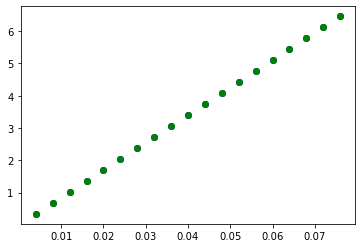

In [3]:
input_resistance_passive = est_input_resistantce(0.1, passive=True, block='', name= '', setIh = False,  gIhbar_Ih = 0.)

In [4]:
print(input_resistance_passive)

84.99654385948214


-88.76530825082467
75.71002813272949


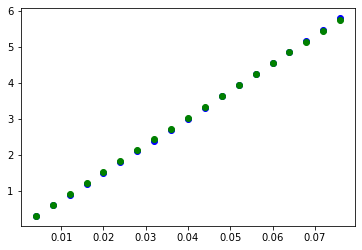

In [5]:
input_resistance_active = est_input_resistantce(0.1, passive=False, block='', name= '', setIh = True,  gIhbar_Ih = 0.0002/20.)
print(input_resistance_active)

-89.7252638809804
80.78918122569365


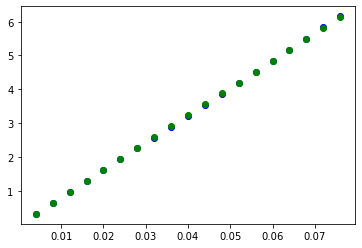

In [6]:
input_resistance_blockIh = est_input_resistantce(0.1, passive=False, block='', name= '', setIh = True,  gIhbar_Ih = 0.0)
print(input_resistance_blockIh)

# recover time constants

In [ ]:
def time_constant_fitting(run_dt, dtime, fE, passive=False, E = True, loc=58,
                          block='',name= '', location ='dend', plot = False,
                          setIh = False, gIhbar_Ih = 0.):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    if setIh:
        for sec in h.allsec():
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = gIhbar_Ih
             
    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -77.
    v_clamp = -77.


    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        if passive:
            syn.e = 0.  # mV for E input and -100 for I input
        else:
            syn.e = 13.6
    else: 
        if passive:
            syn.e = -100.
        else: 
            syn.e = -86.4
    # print(syn.e)
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0e-2  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur2 = h.tstop
    vclamp.amp2 = v_clamp - 20.


    irec = h.Vector()
    irec.record(vclamp._ref_i)
    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()
        
    def delaysec(delay):
        vclamp.rs = 1e9
        h.cvode.event(delay, lambda: setattr(vclamp, 'rs', 1e-2))

    # Main simulation loop
    def main():
        # vol = h.Vector()
    
        # savdata = open("neuron_voltage.dat", "w")
        T = 200./run_dt+1
        N = int(10./dtime)
        data = np.zeros((2*N, int(T)))
        data_V = np.zeros((2*N, int(T)))


        for i in range(1, N+1):
            starttime = 100. + i * dtime
            vclamp.dur1 = starttime
            fih = h.FInitializeHandler(lambda: delaysec(starttime))

            ncstim.weight[0] = 0e-2
            go()
            data_V[2*(i-1),:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1),:] = irec.to_python()  # Assuming irec is a NEURON Vector

            
            ncstim.weight[0] = fE
            go()
            data_V[2*(i-1)+1,:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1)+1,:] = irec.to_python()  # Assuming irec is a NEURON Vector
            
        # if passive:
        #     input_resistance = 84.99654385948214
        # elif block:
        #     input_resistance = 80.78918122569365
        # else:
        #     input_resistance = 75.71002813272949
        # print(input_resistance)
            
        # print("Done data!")
        # I_w_ng = data[::2, :]
        # I_w_g = data[1::2, :]
        K_SS=(data_V[0,-1]+90)/data[0,-1]
        diff_I = data[::2, :] - data[1::2, :]
        VE = data_V[1::2, :] - data_V[::2, :]
        f_VE = np.sum(VE, axis=1)/84.78206013308736
        I_syn_inj = np.sum(diff_I, axis=1)  # size of 100
        x = np.arange(0.1, 10.1, dtime) # ms
        y = I_syn_inj + f_VE
        
        result_lambdas, result_multipliers = exp_fitting(x, y, num=2)
        if plot:
            plt.plot(x, y, 'b', label='data')
            plt.plot(x, result_multipliers[0]+result_multipliers[1]*np.exp(result_lambdas[0]*x) + result_multipliers[2]*np.exp(result_lambdas[1]*x), 'r', label='fit')
            plt.legend()
        
        return result_lambdas, y
    
    result_lambdas, y = main()
    return result_lambdas, y

[-1.4031702  -0.04163643]


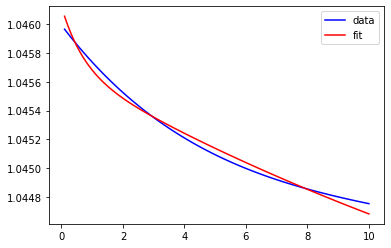

In [3]:
result_lambdas, y = time_constant_fitting(0.1, 0.1, 5e-4, passive = False, E = True, loc = 64,
                          block = '', name = '', location = 'apic', plot = True,
                          setIh = True, gIhbar_Ih = 0.) 
print(result_lambdas)

[ 0.71267192 24.01743157]


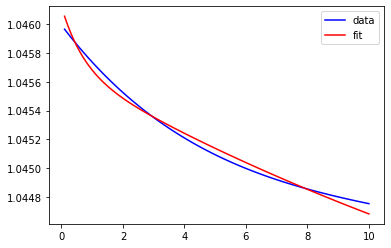

In [31]:
x = np.arange(0.1, 10.1, 0.1) # ms
# Calculate integrals
iy1 = cumtrapz(y, x, initial=0)
iy2 = cumtrapz(iy1, x, initial=0)


# Get exponentials lambdas
Y = np.column_stack((iy1, iy2,  x**2, x, np.ones_like(x)))
A = pinv(Y) @ y

if A[0]**2 + 4*A[1]<0 or A[0]>0 or A[1]>0:
    # 定义目标函数
    def objective(t):
        return np.linalg.norm(Y @ t - y)

    # 定义约束函数
    def constraint1(t):
        return t[0]**2 + 4*t[1]

    def constraint2(t):
        return  1e-6 - t[1] # 避免数值误差导致x[1]恰好等于0

    def constraint3(t):
        return 1e-6 - t[0]  # 避免数值误差导致x[0]恰好等于0


    # 初始猜测
    x0 = np.array([-1.2, -0.2, 0, 0, 0])

    # 定义约束
    cons = [{'type': 'ineq', 'fun': constraint1},
            {'type': 'ineq', 'fun': constraint2},
            {'type': 'ineq', 'fun': constraint3}]

    # 设置迭代次数
    options = {'maxiter': 10000}  # 将最大迭代次数设置为1000

    # 使用scipy.optimize.minimize求解问题
    solution = minimize(objective, x0, constraints=cons, options=options, tol=1e-6)
    A = solution.x


lambdas = eig(np.array([[A[0], A[1]], [1, 0]]))[0]
# print("Lambdas:", lambdas)

# Get exponentials multipliers
X = np.column_stack((np.ones_like(x), np.exp(lambdas[0] * x), np.exp(lambdas[1] * x)))
result_multipliers = pinv(X) @ y
plt.plot(x, y, 'b', label='data')
plt.plot(x, result_multipliers[0]+result_multipliers[1]*np.exp(result_lambdas[0]*x) + result_multipliers[2]*np.exp(result_lambdas[1]*x), 'r', label='fit')
plt.legend()
print(-1./lambdas)

[0.57103884 6.49320681]


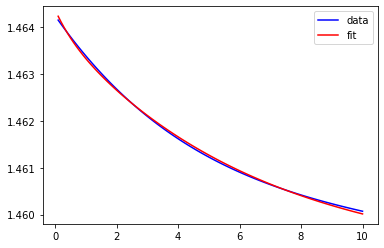

In [27]:
result_lambdas, result_multipliers = exp_fitting(x, y, num=2)
plt.plot(x, y, 'b', label='data')
plt.plot(x, result_multipliers[0]+result_multipliers[1]*np.exp(result_lambdas[0]*x) + result_multipliers[2]*np.exp(result_lambdas[1]*x), 'r', label='fit')
plt.legend()
print(-1./result_lambdas)

# location

In [5]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    estimated_lambda = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = True, E = True, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = False, gIhbar_Ih = 0.0002/20.)
     
    return estimated_lambda

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
np.savetxt("estimated_lambdas_passive_alldend_fE5e4_once_clamp_add_constraint.txt", estimated_lambdas)

In [6]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    estimated_lambda = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = True, E = False, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = False, gIhbar_Ih = 0.0002/20.)
     
    return estimated_lambda

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
np.savetxt("estimated_lambdas_passive_alldend_fI5e4_once_clamp_add_constraint.txt", estimated_lambdas)

In [7]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    estimated_lambda = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = False, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = True, gIhbar_Ih = 0.0002/20.)
     
    return estimated_lambda

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
np.savetxt("estimated_lambdas_active_alldend_fI5e4_once_clamp_add_constraint.txt", estimated_lambdas)

In [8]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    estimated_lambda = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = True, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = True, gIhbar_Ih = 0.0002/20.)
     
    return estimated_lambda

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
np.savetxt("estimated_lambdas_active_alldend_fE5e4_once_clamp_add_constraint.txt", estimated_lambdas)

In [9]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    estimated_lambda = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = True, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = True, gIhbar_Ih = 0.0/20.)
     
    return estimated_lambda

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
np.savetxt("estimated_lambdas_active_alldend_fE5e4_once_clamp_blockIh_add_constraint.txt", estimated_lambdas)

In [10]:
# Your existing functions and code
def time_constant_fitting_parallel(args,):
    loc0, = args
    estimated_lambda = time_constant_fitting(
        0.1, 0.1, 5e-4, passive = False, E = False, block='', name='', 
        loc = loc0[1], location = loc0[0], setIh = True, gIhbar_Ih = 0.0/20.)
     
    return estimated_lambda

 
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(loc0,) for loc0 in loc]

    # Apply the function in parallel
    results = pool.map(time_constant_fitting_parallel, args_list)

# Process the results
estimated_lambdas = np.zeros((Num, 2))
for i, result in enumerate(results):
    estimated_lambdas[i, :] = result
    
np.savetxt("estimated_lambdas_active_alldend_fI5e4_once_clamp_blockIh_add_constraint.txt", estimated_lambdas)

In [47]:
Num = 109 + 84
loc = np.zeros((Num, 2), dtype=object)
loc[:109,0] = 'apic'
loc[109:,0] = 'dend'
loc[:109,1] = np.arange(0,109,1).astype(int)
loc[109:,1] = np.arange(0,84,1).astype(int)
print(loc)


[['apic' 0]
 ['apic' 1]
 ['apic' 2]
 ['apic' 3]
 ['apic' 4]
 ['apic' 5]
 ['apic' 6]
 ['apic' 7]
 ['apic' 8]
 ['apic' 9]
 ['apic' 10]
 ['apic' 11]
 ['apic' 12]
 ['apic' 13]
 ['apic' 14]
 ['apic' 15]
 ['apic' 16]
 ['apic' 17]
 ['apic' 18]
 ['apic' 19]
 ['apic' 20]
 ['apic' 21]
 ['apic' 22]
 ['apic' 23]
 ['apic' 24]
 ['apic' 25]
 ['apic' 26]
 ['apic' 27]
 ['apic' 28]
 ['apic' 29]
 ['apic' 30]
 ['apic' 31]
 ['apic' 32]
 ['apic' 33]
 ['apic' 34]
 ['apic' 35]
 ['apic' 36]
 ['apic' 37]
 ['apic' 38]
 ['apic' 39]
 ['apic' 40]
 ['apic' 41]
 ['apic' 42]
 ['apic' 43]
 ['apic' 44]
 ['apic' 45]
 ['apic' 46]
 ['apic' 47]
 ['apic' 48]
 ['apic' 49]
 ['apic' 50]
 ['apic' 51]
 ['apic' 52]
 ['apic' 53]
 ['apic' 54]
 ['apic' 55]
 ['apic' 56]
 ['apic' 57]
 ['apic' 58]
 ['apic' 59]
 ['apic' 60]
 ['apic' 61]
 ['apic' 62]
 ['apic' 63]
 ['apic' 64]
 ['apic' 65]
 ['apic' 66]
 ['apic' 67]
 ['apic' 68]
 ['apic' 69]
 ['apic' 70]
 ['apic' 71]
 ['apic' 72]
 ['apic' 73]
 ['apic' 74]
 ['apic' 75]
 ['apic' 76]
 ['apic' 